<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:12:43] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


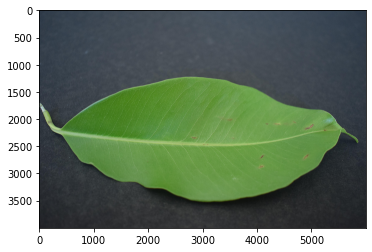

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

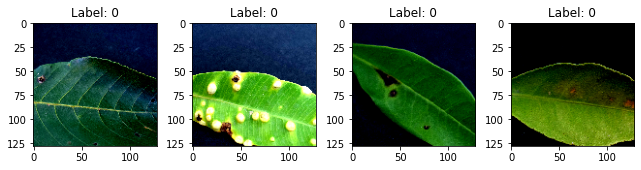

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:12:50] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:12:52] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2582053589393865 samples/sec                   batch loss = 0.48003309965133667 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2645042467787289 samples/sec                   batch loss = 0.47131502628326416 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2624805206737648 samples/sec                   batch loss = 0.6103848218917847 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2660062420389855 samples/sec                   batch loss = 1.5432987213134766 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.265406676648294 samples/sec                   batch loss = 1.546304702758789 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2676755804790598 samples/sec                   batch loss = 0.3595917522907257 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2704947467153624 samples/sec                   batch loss = 0.6925321817398071 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2676049910520042 samples/sec                   batch loss = 0.5021238923072815 | accuracy = 0.56875


Epoch[1] Batch[45] Speed: 1.2736668424385764 samples/sec                   batch loss = 0.8058072924613953 | accuracy = 0.5555555555555556


Epoch[1] Batch[50] Speed: 1.270049252476969 samples/sec                   batch loss = 2.154019832611084 | accuracy = 0.56


Epoch[1] Batch[55] Speed: 1.2702332983544797 samples/sec                   batch loss = 0.8181180953979492 | accuracy = 0.5590909090909091


Epoch[1] Batch[60] Speed: 1.2676615960603788 samples/sec                   batch loss = 0.9060068130493164 | accuracy = 0.5583333333333333


Epoch[1] Batch[65] Speed: 1.2693546091687276 samples/sec                   batch loss = 0.8825916051864624 | accuracy = 0.5692307692307692


Epoch[1] Batch[70] Speed: 1.2662300190388671 samples/sec                   batch loss = 0.43768003582954407 | accuracy = 0.5821428571428572


Epoch[1] Batch[75] Speed: 1.268536407441057 samples/sec                   batch loss = 0.6680713295936584 | accuracy = 0.59


Epoch[1] Batch[80] Speed: 1.2677664867217584 samples/sec                   batch loss = 0.27193334698677063 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.2652145807070871 samples/sec                   batch loss = 0.5470465421676636 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2699134158338763 samples/sec                   batch loss = 0.4405475854873657 | accuracy = 0.6138888888888889


Epoch[1] Batch[95] Speed: 1.2636764837029484 samples/sec                   batch loss = 0.8625615835189819 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2683637841554924 samples/sec                   batch loss = 0.27381253242492676 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.264812351140318 samples/sec                   batch loss = 0.7551841735839844 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.2633153736581542 samples/sec                   batch loss = 1.2972074747085571 | accuracy = 0.625


Epoch[1] Batch[115] Speed: 1.2688737338274947 samples/sec                   batch loss = 0.8320657014846802 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.2705318853429597 samples/sec                   batch loss = 0.6595032215118408 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2614490800908724 samples/sec                   batch loss = 0.5558223724365234 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.2676766341121444 samples/sec                   batch loss = 0.4609675407409668 | accuracy = 0.6423076923076924


Epoch[1] Batch[135] Speed: 1.2661720128796647 samples/sec                   batch loss = 0.18920615315437317 | accuracy = 0.65


Epoch[1] Batch[140] Speed: 1.2660542967829413 samples/sec                   batch loss = 0.9522690773010254 | accuracy = 0.65


Epoch[1] Batch[145] Speed: 1.270329958222833 samples/sec                   batch loss = 0.35579535365104675 | accuracy = 0.6551724137931034


Epoch[1] Batch[150] Speed: 1.2682731757364631 samples/sec                   batch loss = 0.8945031762123108 | accuracy = 0.6583333333333333


Epoch[1] Batch[155] Speed: 1.267208036066586 samples/sec                   batch loss = 0.3008309602737427 | accuracy = 0.6629032258064517


Epoch[1] Batch[160] Speed: 1.2714317651507745 samples/sec                   batch loss = 0.2363407164812088 | accuracy = 0.6671875


Epoch[1] Batch[165] Speed: 1.2676140896548322 samples/sec                   batch loss = 0.6515927910804749 | accuracy = 0.6696969696969697


Epoch[1] Batch[170] Speed: 1.2699770525965992 samples/sec                   batch loss = 0.760458767414093 | accuracy = 0.6691176470588235


Epoch[1] Batch[175] Speed: 1.2677095849761006 samples/sec                   batch loss = 0.5020277500152588 | accuracy = 0.6657142857142857


Epoch[1] Batch[180] Speed: 1.265624513194967 samples/sec                   batch loss = 0.7182270288467407 | accuracy = 0.6625


Epoch[1] Batch[185] Speed: 1.2743367886655441 samples/sec                   batch loss = 0.7220560908317566 | accuracy = 0.6648648648648648


Epoch[1] Batch[190] Speed: 1.2716584283180292 samples/sec                   batch loss = 0.5027464628219604 | accuracy = 0.6631578947368421


Epoch[1] Batch[195] Speed: 1.2722233175504956 samples/sec                   batch loss = 0.5935449004173279 | accuracy = 0.658974358974359


Epoch[1] Batch[200] Speed: 1.2734350165604384 samples/sec                   batch loss = 0.5449215173721313 | accuracy = 0.6625


Epoch[1] Batch[205] Speed: 1.2681006240800872 samples/sec                   batch loss = 0.8112908601760864 | accuracy = 0.6609756097560976


Epoch[1] Batch[210] Speed: 1.269475917571766 samples/sec                   batch loss = 1.3300907611846924 | accuracy = 0.6571428571428571


Epoch[1] Batch[215] Speed: 1.276084669413366 samples/sec                   batch loss = 0.3405401110649109 | accuracy = 0.6569767441860465


Epoch[1] Batch[220] Speed: 1.2700393497439855 samples/sec                   batch loss = 0.5600525736808777 | accuracy = 0.6545454545454545


Epoch[1] Batch[225] Speed: 1.27143754637008 samples/sec                   batch loss = 0.45804840326309204 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.2732529406550495 samples/sec                   batch loss = 0.6508727669715881 | accuracy = 0.657608695652174


Epoch[1] Batch[235] Speed: 1.2745562585095307 samples/sec                   batch loss = 0.30504244565963745 | accuracy = 0.6553191489361702


Epoch[1] Batch[240] Speed: 1.2724753555406763 samples/sec                   batch loss = 0.870408833026886 | accuracy = 0.6552083333333333


Epoch[1] Batch[245] Speed: 1.2744304921705611 samples/sec                   batch loss = 0.7347375154495239 | accuracy = 0.6540816326530612


Epoch[1] Batch[250] Speed: 1.2714693440160545 samples/sec                   batch loss = 0.4005680978298187 | accuracy = 0.657


Epoch[1] Batch[255] Speed: 1.2726929295562117 samples/sec                   batch loss = 0.8198143839836121 | accuracy = 0.6598039215686274


Epoch[1] Batch[260] Speed: 1.2783767681463425 samples/sec                   batch loss = 0.500630795955658 | accuracy = 0.6615384615384615


Epoch[1] Batch[265] Speed: 1.2745818214471898 samples/sec                   batch loss = 0.5622372627258301 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.265358766488313 samples/sec                   batch loss = 0.980444610118866 | accuracy = 0.6601851851851852


Epoch[1] Batch[275] Speed: 1.2663440400436425 samples/sec                   batch loss = 0.511333703994751 | accuracy = 0.6627272727272727


Epoch[1] Batch[280] Speed: 1.276604927477873 samples/sec                   batch loss = 0.6486166715621948 | accuracy = 0.6625


Epoch[1] Batch[285] Speed: 1.271059854200849 samples/sec                   batch loss = 0.6479955315589905 | accuracy = 0.6614035087719298


Epoch[1] Batch[290] Speed: 1.2715923098798048 samples/sec                   batch loss = 0.36327463388442993 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2667013368559212 samples/sec                   batch loss = 0.40726131200790405 | accuracy = 0.6669491525423729


Epoch[1] Batch[300] Speed: 1.2587219031672163 samples/sec                   batch loss = 0.5322798490524292 | accuracy = 0.6666666666666666


Epoch[1] Batch[305] Speed: 1.2623621601712824 samples/sec                   batch loss = 0.23484206199645996 | accuracy = 0.6672131147540984


Epoch[1] Batch[310] Speed: 1.269769343468753 samples/sec                   batch loss = 0.8452378511428833 | accuracy = 0.6685483870967742


Epoch[1] Batch[315] Speed: 1.2697685746579042 samples/sec                   batch loss = 0.2830030024051666 | accuracy = 0.6698412698412698


Epoch[1] Batch[320] Speed: 1.262700486965459 samples/sec                   batch loss = 0.3652893006801605 | accuracy = 0.6703125


Epoch[1] Batch[325] Speed: 1.2716390547107 samples/sec                   batch loss = 0.9205675721168518 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2757637735963263 samples/sec                   batch loss = 0.5435253977775574 | accuracy = 0.6734848484848485


Epoch[1] Batch[335] Speed: 1.2750790501592784 samples/sec                   batch loss = 0.2640681266784668 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.2696339510141161 samples/sec                   batch loss = 0.5809308886528015 | accuracy = 0.6713235294117647


Epoch[1] Batch[345] Speed: 1.2764803104477012 samples/sec                   batch loss = 0.2917879521846771 | accuracy = 0.6710144927536232


Epoch[1] Batch[350] Speed: 1.2696226135666477 samples/sec                   batch loss = 0.564113974571228 | accuracy = 0.6714285714285714


Epoch[1] Batch[355] Speed: 1.2654332101304857 samples/sec                   batch loss = 0.536553144454956 | accuracy = 0.671830985915493


Epoch[1] Batch[360] Speed: 1.262380492247562 samples/sec                   batch loss = 0.782418966293335 | accuracy = 0.6701388888888888


Epoch[1] Batch[365] Speed: 1.2656166842899215 samples/sec                   batch loss = 0.9737758636474609 | accuracy = 0.6678082191780822


Epoch[1] Batch[370] Speed: 1.2715356424048532 samples/sec                   batch loss = 0.39933040738105774 | accuracy = 0.6682432432432432


Epoch[1] Batch[375] Speed: 1.2654203250271379 samples/sec                   batch loss = 0.6196110248565674 | accuracy = 0.666


Epoch[1] Batch[380] Speed: 1.2753412369974184 samples/sec                   batch loss = 0.38166648149490356 | accuracy = 0.6644736842105263


Epoch[1] Batch[385] Speed: 1.269688815590915 samples/sec                   batch loss = 0.5554814338684082 | accuracy = 0.6642857142857143


Epoch[1] Batch[390] Speed: 1.2742912003111062 samples/sec                   batch loss = 0.745871901512146 | accuracy = 0.6641025641025641


Epoch[1] Batch[395] Speed: 1.2676862126750668 samples/sec                   batch loss = 0.9961901307106018 | accuracy = 0.6639240506329114


Epoch[1] Batch[400] Speed: 1.274807381341367 samples/sec                   batch loss = 0.9806321263313293 | accuracy = 0.663125


Epoch[1] Batch[405] Speed: 1.2712137552089202 samples/sec                   batch loss = 0.8127608299255371 | accuracy = 0.6648148148148149


Epoch[1] Batch[410] Speed: 1.2647118575405656 samples/sec                   batch loss = 0.43394091725349426 | accuracy = 0.6652439024390244


Epoch[1] Batch[415] Speed: 1.2694901341675726 samples/sec                   batch loss = 0.5644403100013733 | accuracy = 0.6668674698795181


Epoch[1] Batch[420] Speed: 1.2669942468311959 samples/sec                   batch loss = 1.581404685974121 | accuracy = 0.6678571428571428


Epoch[1] Batch[425] Speed: 1.2745942159678914 samples/sec                   batch loss = 0.6340681314468384 | accuracy = 0.6694117647058824


Epoch[1] Batch[430] Speed: 1.272726624465516 samples/sec                   batch loss = 0.6819621324539185 | accuracy = 0.6686046511627907


Epoch[1] Batch[435] Speed: 1.2680095740783695 samples/sec                   batch loss = 0.4901924431324005 | accuracy = 0.6701149425287356


Epoch[1] Batch[440] Speed: 1.26882920721468 samples/sec                   batch loss = 0.3587333858013153 | accuracy = 0.6698863636363637


Epoch[1] Batch[445] Speed: 1.2690864298986468 samples/sec                   batch loss = 0.44068557024002075 | accuracy = 0.6702247191011236


Epoch[1] Batch[450] Speed: 1.26703644391546 samples/sec                   batch loss = 0.4820551872253418 | accuracy = 0.6711111111111111


Epoch[1] Batch[455] Speed: 1.2653466463654692 samples/sec                   batch loss = 0.4159410893917084 | accuracy = 0.6725274725274726


Epoch[1] Batch[460] Speed: 1.2658697406098265 samples/sec                   batch loss = 0.36887213587760925 | accuracy = 0.6717391304347826


Epoch[1] Batch[465] Speed: 1.267480496977109 samples/sec                   batch loss = 0.3777402937412262 | accuracy = 0.6731182795698925


Epoch[1] Batch[470] Speed: 1.2736422830736585 samples/sec                   batch loss = 0.5016731023788452 | accuracy = 0.6718085106382978


Epoch[1] Batch[475] Speed: 1.267392599737233 samples/sec                   batch loss = 0.8606139421463013 | accuracy = 0.6721052631578948


Epoch[1] Batch[480] Speed: 1.272783398147573 samples/sec                   batch loss = 0.3109220564365387 | accuracy = 0.6729166666666667


Epoch[1] Batch[485] Speed: 1.2694338459983272 samples/sec                   batch loss = 0.9213656187057495 | accuracy = 0.6721649484536083


Epoch[1] Batch[490] Speed: 1.265615825025754 samples/sec                   batch loss = 0.388583242893219 | accuracy = 0.673469387755102


Epoch[1] Batch[495] Speed: 1.2683859348493338 samples/sec                   batch loss = 0.8209908604621887 | accuracy = 0.6727272727272727


Epoch[1] Batch[500] Speed: 1.2678850005248463 samples/sec                   batch loss = 0.7708714604377747 | accuracy = 0.6725


Epoch[1] Batch[505] Speed: 1.2721751792316833 samples/sec                   batch loss = 0.5772225856781006 | accuracy = 0.6737623762376238


Epoch[1] Batch[510] Speed: 1.2738631580162219 samples/sec                   batch loss = 0.5854566097259521 | accuracy = 0.6725490196078432


Epoch[1] Batch[515] Speed: 1.2731580576124493 samples/sec                   batch loss = 0.4252934455871582 | accuracy = 0.6723300970873787


Epoch[1] Batch[520] Speed: 1.277420929713211 samples/sec                   batch loss = 0.8001798391342163 | accuracy = 0.6716346153846153


Epoch[1] Batch[525] Speed: 1.277096445154906 samples/sec                   batch loss = 0.5765151977539062 | accuracy = 0.6719047619047619


Epoch[1] Batch[530] Speed: 1.2721667867514372 samples/sec                   batch loss = 0.28185349702835083 | accuracy = 0.6726415094339623


Epoch[1] Batch[535] Speed: 1.2710130556519579 samples/sec                   batch loss = 0.3468615710735321 | accuracy = 0.672429906542056


Epoch[1] Batch[540] Speed: 1.266363443818102 samples/sec                   batch loss = 0.4488227367401123 | accuracy = 0.6731481481481482


Epoch[1] Batch[545] Speed: 1.2707435977373072 samples/sec                   batch loss = 0.33434897661209106 | accuracy = 0.6743119266055045


Epoch[1] Batch[550] Speed: 1.2680218411059168 samples/sec                   batch loss = 0.3718208074569702 | accuracy = 0.675


Epoch[1] Batch[555] Speed: 1.2675638095358979 samples/sec                   batch loss = 0.6821666359901428 | accuracy = 0.6747747747747748


Epoch[1] Batch[560] Speed: 1.267065629484178 samples/sec                   batch loss = 0.8128176331520081 | accuracy = 0.6754464285714286


Epoch[1] Batch[565] Speed: 1.2705599812913455 samples/sec                   batch loss = 0.3224932849407196 | accuracy = 0.6747787610619469


Epoch[1] Batch[570] Speed: 1.2696684450019737 samples/sec                   batch loss = 0.29071494936943054 | accuracy = 0.6763157894736842


Epoch[1] Batch[575] Speed: 1.2728200913168568 samples/sec                   batch loss = 0.6076613068580627 | accuracy = 0.6769565217391305


Epoch[1] Batch[580] Speed: 1.2767649352824657 samples/sec                   batch loss = 0.5889948606491089 | accuracy = 0.6762931034482759


Epoch[1] Batch[585] Speed: 1.2614827513609432 samples/sec                   batch loss = 0.5473023056983948 | accuracy = 0.6773504273504274


Epoch[1] Batch[590] Speed: 1.270304661731696 samples/sec                   batch loss = 0.33288243412971497 | accuracy = 0.6775423728813559


Epoch[1] Batch[595] Speed: 1.270565369697425 samples/sec                   batch loss = 0.4910494089126587 | accuracy = 0.6773109243697479


Epoch[1] Batch[600] Speed: 1.2724150387403943 samples/sec                   batch loss = 0.2845531404018402 | accuracy = 0.6779166666666666


Epoch[1] Batch[605] Speed: 1.26969736758957 samples/sec                   batch loss = 0.3729240596294403 | accuracy = 0.6785123966942149


Epoch[1] Batch[610] Speed: 1.273975945955017 samples/sec                   batch loss = 0.720292329788208 | accuracy = 0.6795081967213115


Epoch[1] Batch[615] Speed: 1.2731567050032888 samples/sec                   batch loss = 0.34673047065734863 | accuracy = 0.6800813008130081


Epoch[1] Batch[620] Speed: 1.2731193161592556 samples/sec                   batch loss = 0.2553776800632477 | accuracy = 0.6818548387096774


Epoch[1] Batch[625] Speed: 1.27520387835759 samples/sec                   batch loss = 0.2964116632938385 | accuracy = 0.6828


Epoch[1] Batch[630] Speed: 1.2724160037641854 samples/sec                   batch loss = 0.47290921211242676 | accuracy = 0.6841269841269841


Epoch[1] Batch[635] Speed: 1.2733867865032908 samples/sec                   batch loss = 2.2602219581604004 | accuracy = 0.6846456692913386


Epoch[1] Batch[640] Speed: 1.2672541719446213 samples/sec                   batch loss = 0.3368908166885376 | accuracy = 0.68515625


Epoch[1] Batch[645] Speed: 1.2687889056475468 samples/sec                   batch loss = 0.5610458254814148 | accuracy = 0.6852713178294574


Epoch[1] Batch[650] Speed: 1.2788678967128326 samples/sec                   batch loss = 0.3248608708381653 | accuracy = 0.6861538461538461


Epoch[1] Batch[655] Speed: 1.2690508156139122 samples/sec                   batch loss = 0.5076588988304138 | accuracy = 0.6870229007633588


Epoch[1] Batch[660] Speed: 1.272014873064376 samples/sec                   batch loss = 0.8552097678184509 | accuracy = 0.6871212121212121


Epoch[1] Batch[665] Speed: 1.2755909235541063 samples/sec                   batch loss = 0.7818641662597656 | accuracy = 0.6857142857142857


Epoch[1] Batch[670] Speed: 1.2696922748124508 samples/sec                   batch loss = 0.47216254472732544 | accuracy = 0.6854477611940298


Epoch[1] Batch[675] Speed: 1.279322916940703 samples/sec                   batch loss = 0.6605698466300964 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2712886003926949 samples/sec                   batch loss = 0.19090455770492554 | accuracy = 0.6875


Epoch[1] Batch[685] Speed: 1.2785547586590353 samples/sec                   batch loss = 0.5188816785812378 | accuracy = 0.6872262773722628


Epoch[1] Batch[690] Speed: 1.2775733591956684 samples/sec                   batch loss = 0.7321809530258179 | accuracy = 0.6869565217391305


Epoch[1] Batch[695] Speed: 1.2754301432937998 samples/sec                   batch loss = 0.8841170072555542 | accuracy = 0.6874100719424461


Epoch[1] Batch[700] Speed: 1.2739620156603355 samples/sec                   batch loss = 0.44962751865386963 | accuracy = 0.6885714285714286


Epoch[1] Batch[705] Speed: 1.274567490583121 samples/sec                   batch loss = 0.31701087951660156 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.2744803503746516 samples/sec                   batch loss = 0.38152745366096497 | accuracy = 0.6911971830985916


Epoch[1] Batch[715] Speed: 1.2725572025188374 samples/sec                   batch loss = 0.3383144736289978 | accuracy = 0.6923076923076923


Epoch[1] Batch[720] Speed: 1.2729641807499368 samples/sec                   batch loss = 0.41108977794647217 | accuracy = 0.69375


Epoch[1] Batch[725] Speed: 1.2695794754692131 samples/sec                   batch loss = 0.7025171518325806 | accuracy = 0.6948275862068966


Epoch[1] Batch[730] Speed: 1.2749806973280238 samples/sec                   batch loss = 0.44447997212409973 | accuracy = 0.6955479452054795


Epoch[1] Batch[735] Speed: 1.2732047243885345 samples/sec                   batch loss = 0.4096304178237915 | accuracy = 0.6955782312925171


Epoch[1] Batch[740] Speed: 1.2698348880164916 samples/sec                   batch loss = 0.45084914565086365 | accuracy = 0.6952702702702702


Epoch[1] Batch[745] Speed: 1.2735135069485561 samples/sec                   batch loss = 0.31618547439575195 | accuracy = 0.6953020134228188


Epoch[1] Batch[750] Speed: 1.2694499827105212 samples/sec                   batch loss = 0.15337811410427094 | accuracy = 0.696


Epoch[1] Batch[755] Speed: 1.2705595964069458 samples/sec                   batch loss = 0.8332284688949585 | accuracy = 0.6963576158940398


Epoch[1] Batch[760] Speed: 1.2720681110649696 samples/sec                   batch loss = 0.4917016923427582 | accuracy = 0.6967105263157894


Epoch[1] Batch[765] Speed: 1.2748305326226126 samples/sec                   batch loss = 1.1917409896850586 | accuracy = 0.6970588235294117


Epoch[1] Batch[770] Speed: 1.2696106998569825 samples/sec                   batch loss = 1.0148552656173706 | accuracy = 0.6970779220779221


Epoch[1] Batch[775] Speed: 1.2688279597468246 samples/sec                   batch loss = 0.16756600141525269 | accuracy = 0.697741935483871


Epoch[1] Batch[780] Speed: 1.2709088786655576 samples/sec                   batch loss = 0.5246235728263855 | accuracy = 0.6983974358974359


Epoch[1] Batch[785] Speed: 1.272458466260186 samples/sec                   batch loss = 0.43204885721206665 | accuracy = 0.6980891719745222


[Epoch 1] training: accuracy=0.6986040609137056
[Epoch 1] time cost: 647.4439442157745
[Epoch 1] validation: validation accuracy=0.7111111111111111


Epoch[2] Batch[5] Speed: 1.277484153864768 samples/sec                   batch loss = 0.7336045503616333 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2822843429112991 samples/sec                   batch loss = 0.25865134596824646 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2723293504636393 samples/sec                   batch loss = 0.30546554923057556 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2744586639967974 samples/sec                   batch loss = 0.25750717520713806 | accuracy = 0.825


Epoch[2] Batch[25] Speed: 1.2768887332554641 samples/sec                   batch loss = 0.5718219876289368 | accuracy = 0.83


Epoch[2] Batch[30] Speed: 1.27719619420684 samples/sec                   batch loss = 0.5880414843559265 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.2737342405222964 samples/sec                   batch loss = 0.11139457672834396 | accuracy = 0.8071428571428572


Epoch[2] Batch[40] Speed: 1.26818248440077 samples/sec                   batch loss = 0.6952404379844666 | accuracy = 0.8125


Epoch[2] Batch[45] Speed: 1.2710559060420175 samples/sec                   batch loss = 0.15087105333805084 | accuracy = 0.8111111111111111


Epoch[2] Batch[50] Speed: 1.2767428796075198 samples/sec                   batch loss = 0.2511724829673767 | accuracy = 0.815


Epoch[2] Batch[55] Speed: 1.2746275274367698 samples/sec                   batch loss = 0.3124130964279175 | accuracy = 0.8181818181818182


Epoch[2] Batch[60] Speed: 1.267623188388277 samples/sec                   batch loss = 0.3876429498195648 | accuracy = 0.8125


Epoch[2] Batch[65] Speed: 1.2696915060949252 samples/sec                   batch loss = 0.5083667039871216 | accuracy = 0.8076923076923077


Epoch[2] Batch[70] Speed: 1.2725278599386354 samples/sec                   batch loss = 0.23090383410453796 | accuracy = 0.8035714285714286


Epoch[2] Batch[75] Speed: 1.2792075221954173 samples/sec                   batch loss = 0.4647175967693329 | accuracy = 0.7866666666666666


Epoch[2] Batch[80] Speed: 1.2825254808548632 samples/sec                   batch loss = 0.3811521828174591 | accuracy = 0.7875


Epoch[2] Batch[85] Speed: 1.2730042650443159 samples/sec                   batch loss = 0.6420881748199463 | accuracy = 0.7794117647058824


Epoch[2] Batch[90] Speed: 1.2753815680887022 samples/sec                   batch loss = 0.3589347302913666 | accuracy = 0.7722222222222223


Epoch[2] Batch[95] Speed: 1.2729598344118869 samples/sec                   batch loss = 0.6497852802276611 | accuracy = 0.7763157894736842


Epoch[2] Batch[100] Speed: 1.2767314148440165 samples/sec                   batch loss = 0.6282095313072205 | accuracy = 0.78


Epoch[2] Batch[105] Speed: 1.2743848971116645 samples/sec                   batch loss = 0.46646806597709656 | accuracy = 0.7833333333333333


Epoch[2] Batch[110] Speed: 1.2759634533239685 samples/sec                   batch loss = 0.504015326499939 | accuracy = 0.7772727272727272


Epoch[2] Batch[115] Speed: 1.2767411307319818 samples/sec                   batch loss = 0.6506057977676392 | accuracy = 0.7782608695652173


Epoch[2] Batch[120] Speed: 1.2812492649540796 samples/sec                   batch loss = 0.5022480487823486 | accuracy = 0.775


Epoch[2] Batch[125] Speed: 1.2758476935644476 samples/sec                   batch loss = 0.12638863921165466 | accuracy = 0.776


Epoch[2] Batch[130] Speed: 1.2746569669283312 samples/sec                   batch loss = 0.6311975121498108 | accuracy = 0.7692307692307693


Epoch[2] Batch[135] Speed: 1.2731056944130372 samples/sec                   batch loss = 0.7568996548652649 | accuracy = 0.7666666666666667


Epoch[2] Batch[140] Speed: 1.2766147385811717 samples/sec                   batch loss = 0.31976068019866943 | accuracy = 0.775


Epoch[2] Batch[145] Speed: 1.2767167441334148 samples/sec                   batch loss = 1.014636754989624 | accuracy = 0.7689655172413793


Epoch[2] Batch[150] Speed: 1.2738179904031726 samples/sec                   batch loss = 0.6199949979782104 | accuracy = 0.7666666666666667


Epoch[2] Batch[155] Speed: 1.2770341342102436 samples/sec                   batch loss = 0.38128578662872314 | accuracy = 0.7661290322580645


Epoch[2] Batch[160] Speed: 1.2760687518159235 samples/sec                   batch loss = 0.36086973547935486 | accuracy = 0.7640625


Epoch[2] Batch[165] Speed: 1.2795079041027388 samples/sec                   batch loss = 0.5655820965766907 | accuracy = 0.7636363636363637


Epoch[2] Batch[170] Speed: 1.2795493774470295 samples/sec                   batch loss = 0.7465720772743225 | accuracy = 0.763235294117647


Epoch[2] Batch[175] Speed: 1.2826611853236154 samples/sec                   batch loss = 0.6274523735046387 | accuracy = 0.7642857142857142


Epoch[2] Batch[180] Speed: 1.2756897585565616 samples/sec                   batch loss = 0.36490610241889954 | accuracy = 0.7652777777777777


Epoch[2] Batch[185] Speed: 1.2794636037824414 samples/sec                   batch loss = 0.7012671232223511 | accuracy = 0.7621621621621621


Epoch[2] Batch[190] Speed: 1.2728242435718917 samples/sec                   batch loss = 0.6797292232513428 | accuracy = 0.7605263157894737


Epoch[2] Batch[195] Speed: 1.2716919720787732 samples/sec                   batch loss = 0.23934300243854523 | accuracy = 0.7615384615384615


Epoch[2] Batch[200] Speed: 1.2788327061084075 samples/sec                   batch loss = 0.21049588918685913 | accuracy = 0.76


Epoch[2] Batch[205] Speed: 1.272427584163854 samples/sec                   batch loss = 0.23146408796310425 | accuracy = 0.7634146341463415


Epoch[2] Batch[210] Speed: 1.2768465576235328 samples/sec                   batch loss = 0.2408522516489029 | accuracy = 0.7619047619047619


Epoch[2] Batch[215] Speed: 1.2826072530861838 samples/sec                   batch loss = 0.3907214105129242 | accuracy = 0.7593023255813953


Epoch[2] Batch[220] Speed: 1.2786213108073698 samples/sec                   batch loss = 0.8280196785926819 | accuracy = 0.7568181818181818


Epoch[2] Batch[225] Speed: 1.2693062075363453 samples/sec                   batch loss = 0.12338525801897049 | accuracy = 0.76


Epoch[2] Batch[230] Speed: 1.2715594459840514 samples/sec                   batch loss = 1.0323503017425537 | accuracy = 0.758695652173913


Epoch[2] Batch[235] Speed: 1.2744014503545482 samples/sec                   batch loss = 0.6496120095252991 | accuracy = 0.7542553191489362


Epoch[2] Batch[240] Speed: 1.2696104116248412 samples/sec                   batch loss = 0.7273699045181274 | accuracy = 0.7572916666666667


Epoch[2] Batch[245] Speed: 1.2764299071962117 samples/sec                   batch loss = 0.8145890235900879 | accuracy = 0.7561224489795918


Epoch[2] Batch[250] Speed: 1.268762519103603 samples/sec                   batch loss = 0.8346338272094727 | accuracy = 0.753


Epoch[2] Batch[255] Speed: 1.2647795507146549 samples/sec                   batch loss = 0.45915156602859497 | accuracy = 0.753921568627451


Epoch[2] Batch[260] Speed: 1.2684150867250734 samples/sec                   batch loss = 0.4009456932544708 | accuracy = 0.7548076923076923


Epoch[2] Batch[265] Speed: 1.2758932963267948 samples/sec                   batch loss = 0.35628968477249146 | accuracy = 0.7518867924528302


Epoch[2] Batch[270] Speed: 1.2744707656791425 samples/sec                   batch loss = 0.46255242824554443 | accuracy = 0.7546296296296297


Epoch[2] Batch[275] Speed: 1.2719437995641922 samples/sec                   batch loss = 0.34131157398223877 | accuracy = 0.7545454545454545


Epoch[2] Batch[280] Speed: 1.276194259261189 samples/sec                   batch loss = 0.8960483074188232 | accuracy = 0.7535714285714286


Epoch[2] Batch[285] Speed: 1.2718006158871225 samples/sec                   batch loss = 0.4268750548362732 | accuracy = 0.7517543859649123


Epoch[2] Batch[290] Speed: 1.2753518042723164 samples/sec                   batch loss = 0.7094904780387878 | accuracy = 0.75


Epoch[2] Batch[295] Speed: 1.2719319386814942 samples/sec                   batch loss = 0.18408645689487457 | accuracy = 0.752542372881356


Epoch[2] Batch[300] Speed: 1.2753408492108451 samples/sec                   batch loss = 0.654198944568634 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.2690624308348322 samples/sec                   batch loss = 0.23739129304885864 | accuracy = 0.7524590163934426


Epoch[2] Batch[310] Speed: 1.2673816852446702 samples/sec                   batch loss = 0.4612215757369995 | accuracy = 0.7524193548387097


Epoch[2] Batch[315] Speed: 1.2721989102922882 samples/sec                   batch loss = 0.41568008065223694 | accuracy = 0.7523809523809524


Epoch[2] Batch[320] Speed: 1.2677550868046281 samples/sec                   batch loss = 0.3084927499294281 | accuracy = 0.7546875


Epoch[2] Batch[325] Speed: 1.2720659891753332 samples/sec                   batch loss = 0.22724103927612305 | accuracy = 0.7523076923076923


Epoch[2] Batch[330] Speed: 1.2776625769856613 samples/sec                   batch loss = 0.6253549456596375 | accuracy = 0.753030303030303


Epoch[2] Batch[335] Speed: 1.2772652304514016 samples/sec                   batch loss = 0.4803023636341095 | accuracy = 0.7544776119402985


Epoch[2] Batch[340] Speed: 1.2707159748913937 samples/sec                   batch loss = 0.17176732420921326 | accuracy = 0.7551470588235294


Epoch[2] Batch[345] Speed: 1.2773944746947508 samples/sec                   batch loss = 1.5093300342559814 | accuracy = 0.755072463768116


Epoch[2] Batch[350] Speed: 1.2707978844596985 samples/sec                   batch loss = 0.6556304693222046 | accuracy = 0.7542857142857143


Epoch[2] Batch[355] Speed: 1.2661816642772767 samples/sec                   batch loss = 0.34702277183532715 | accuracy = 0.7556338028169014


Epoch[2] Batch[360] Speed: 1.2757564008088025 samples/sec                   batch loss = 0.27750319242477417 | accuracy = 0.7534722222222222


Epoch[2] Batch[365] Speed: 1.2717382422388732 samples/sec                   batch loss = 0.5436258912086487 | accuracy = 0.7534246575342466


Epoch[2] Batch[370] Speed: 1.2755370023753405 samples/sec                   batch loss = 0.32721465826034546 | accuracy = 0.7520270270270271


Epoch[2] Batch[375] Speed: 1.2702314710956595 samples/sec                   batch loss = 0.36387407779693604 | accuracy = 0.7533333333333333


Epoch[2] Batch[380] Speed: 1.2671480261649821 samples/sec                   batch loss = 0.3321128189563751 | accuracy = 0.7539473684210526


Epoch[2] Batch[385] Speed: 1.2753083729222157 samples/sec                   batch loss = 0.5753023028373718 | accuracy = 0.7538961038961038


Epoch[2] Batch[390] Speed: 1.2667642695076695 samples/sec                   batch loss = 0.20409396290779114 | accuracy = 0.7551282051282051


Epoch[2] Batch[395] Speed: 1.272644176470548 samples/sec                   batch loss = 0.5954174995422363 | accuracy = 0.7556962025316456


Epoch[2] Batch[400] Speed: 1.2724278736765464 samples/sec                   batch loss = 0.19422653317451477 | accuracy = 0.756875


Epoch[2] Batch[405] Speed: 1.2745923761409894 samples/sec                   batch loss = 0.8263382911682129 | accuracy = 0.7580246913580246


Epoch[2] Batch[410] Speed: 1.2718414946723513 samples/sec                   batch loss = 0.4291215240955353 | accuracy = 0.7579268292682927


Epoch[2] Batch[415] Speed: 1.2726468795141233 samples/sec                   batch loss = 0.2265852987766266 | accuracy = 0.7590361445783133


Epoch[2] Batch[420] Speed: 1.2675198536141832 samples/sec                   batch loss = 0.572373628616333 | accuracy = 0.7589285714285714


Epoch[2] Batch[425] Speed: 1.2770166376905272 samples/sec                   batch loss = 0.39584875106811523 | accuracy = 0.76


Epoch[2] Batch[430] Speed: 1.272182510684353 samples/sec                   batch loss = 0.37554994225502014 | accuracy = 0.7616279069767442


Epoch[2] Batch[435] Speed: 1.2752925716247294 samples/sec                   batch loss = 0.3004649579524994 | accuracy = 0.7637931034482759


Epoch[2] Batch[440] Speed: 1.2714048831716191 samples/sec                   batch loss = 0.408893346786499 | accuracy = 0.7636363636363637


Epoch[2] Batch[445] Speed: 1.2757291416370367 samples/sec                   batch loss = 0.38680654764175415 | accuracy = 0.7623595505617977


Epoch[2] Batch[450] Speed: 1.275384961445891 samples/sec                   batch loss = 0.6661368012428284 | accuracy = 0.7622222222222222


Epoch[2] Batch[455] Speed: 1.2735005534346422 samples/sec                   batch loss = 0.27658435702323914 | accuracy = 0.7615384615384615


Epoch[2] Batch[460] Speed: 1.2700848266750566 samples/sec                   batch loss = 0.25080442428588867 | accuracy = 0.7619565217391304


Epoch[2] Batch[465] Speed: 1.2737297922223236 samples/sec                   batch loss = 0.6781971454620361 | accuracy = 0.7618279569892473


Epoch[2] Batch[470] Speed: 1.2713382130611743 samples/sec                   batch loss = 0.25817304849624634 | accuracy = 0.7622340425531915


Epoch[2] Batch[475] Speed: 1.2762839641628763 samples/sec                   batch loss = 0.769291877746582 | accuracy = 0.7636842105263157


Epoch[2] Batch[480] Speed: 1.2763858197544582 samples/sec                   batch loss = 0.3789874017238617 | accuracy = 0.7635416666666667


Epoch[2] Batch[485] Speed: 1.2778768673294194 samples/sec                   batch loss = 0.25268566608428955 | accuracy = 0.7623711340206185


Epoch[2] Batch[490] Speed: 1.2767560934886657 samples/sec                   batch loss = 0.7423181533813477 | accuracy = 0.7627551020408163


Epoch[2] Batch[495] Speed: 1.2697013073131038 samples/sec                   batch loss = 0.7173175811767578 | accuracy = 0.7631313131313131


Epoch[2] Batch[500] Speed: 1.2728119800130808 samples/sec                   batch loss = 0.47336143255233765 | accuracy = 0.7645


Epoch[2] Batch[505] Speed: 1.2734503852219416 samples/sec                   batch loss = 0.594929039478302 | accuracy = 0.7628712871287129


Epoch[2] Batch[510] Speed: 1.271380603651347 samples/sec                   batch loss = 0.8333655595779419 | accuracy = 0.7637254901960784


Epoch[2] Batch[515] Speed: 1.2633752113567813 samples/sec                   batch loss = 0.29500332474708557 | accuracy = 0.762621359223301


Epoch[2] Batch[520] Speed: 1.274068241852508 samples/sec                   batch loss = 0.4948255717754364 | accuracy = 0.7615384615384615


Epoch[2] Batch[525] Speed: 1.2796951897901516 samples/sec                   batch loss = 0.33528557419776917 | accuracy = 0.7614285714285715


Epoch[2] Batch[530] Speed: 1.2775396990140904 samples/sec                   batch loss = 0.380098432302475 | accuracy = 0.7622641509433963


Epoch[2] Batch[535] Speed: 1.271440726063108 samples/sec                   batch loss = 0.6956027746200562 | accuracy = 0.7626168224299066


Epoch[2] Batch[540] Speed: 1.2740404742798939 samples/sec                   batch loss = 0.30349084734916687 | accuracy = 0.7638888888888888


Epoch[2] Batch[545] Speed: 1.2764116503530722 samples/sec                   batch loss = 0.6516947150230408 | accuracy = 0.763302752293578


Epoch[2] Batch[550] Speed: 1.2773248409874005 samples/sec                   batch loss = 0.3007763624191284 | accuracy = 0.7631818181818182


Epoch[2] Batch[555] Speed: 1.2725883804930347 samples/sec                   batch loss = 0.19573183357715607 | accuracy = 0.7621621621621621


Epoch[2] Batch[560] Speed: 1.2773472085294053 samples/sec                   batch loss = 0.1788339465856552 | accuracy = 0.7620535714285714


Epoch[2] Batch[565] Speed: 1.27808266148584 samples/sec                   batch loss = 0.38585102558135986 | accuracy = 0.7628318584070797


Epoch[2] Batch[570] Speed: 1.275394947716094 samples/sec                   batch loss = 0.43233615159988403 | accuracy = 0.762719298245614


Epoch[2] Batch[575] Speed: 1.2725959097684454 samples/sec                   batch loss = 0.6472278833389282 | accuracy = 0.7617391304347826


Epoch[2] Batch[580] Speed: 1.2748967944931124 samples/sec                   batch loss = 0.2877838611602783 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.2731232771472571 samples/sec                   batch loss = 0.2694542706012726 | accuracy = 0.7619658119658119


Epoch[2] Batch[590] Speed: 1.274837700972229 samples/sec                   batch loss = 0.7550462484359741 | accuracy = 0.7614406779661017


Epoch[2] Batch[595] Speed: 1.2646716264393398 samples/sec                   batch loss = 0.6812739372253418 | accuracy = 0.7596638655462185


Epoch[2] Batch[600] Speed: 1.2715641682575225 samples/sec                   batch loss = 0.48060160875320435 | accuracy = 0.7595833333333334


Epoch[2] Batch[605] Speed: 1.270947004305801 samples/sec                   batch loss = 0.48730531334877014 | accuracy = 0.7586776859504132


Epoch[2] Batch[610] Speed: 1.2683939898389167 samples/sec                   batch loss = 0.5022095441818237 | accuracy = 0.759016393442623


Epoch[2] Batch[615] Speed: 1.2741756469944743 samples/sec                   batch loss = 0.47302207350730896 | accuracy = 0.758130081300813


Epoch[2] Batch[620] Speed: 1.2753192304824206 samples/sec                   batch loss = 0.49195191264152527 | accuracy = 0.7568548387096774


Epoch[2] Batch[625] Speed: 1.2712107692904526 samples/sec                   batch loss = 0.20626862347126007 | accuracy = 0.7572


Epoch[2] Batch[630] Speed: 1.2750366063867438 samples/sec                   batch loss = 0.329368531703949 | accuracy = 0.7567460317460317


Epoch[2] Batch[635] Speed: 1.273470684022646 samples/sec                   batch loss = 0.27267923951148987 | accuracy = 0.7562992125984253


Epoch[2] Batch[640] Speed: 1.2742584871115241 samples/sec                   batch loss = 0.7951960563659668 | accuracy = 0.755078125


Epoch[2] Batch[645] Speed: 1.2749761434265479 samples/sec                   batch loss = 0.2632178068161011 | accuracy = 0.7550387596899225


Epoch[2] Batch[650] Speed: 1.2704345213286679 samples/sec                   batch loss = 0.34452083706855774 | accuracy = 0.7557692307692307


Epoch[2] Batch[655] Speed: 1.2715150197814784 samples/sec                   batch loss = 0.4559028446674347 | accuracy = 0.7561068702290077


Epoch[2] Batch[660] Speed: 1.2710534986401334 samples/sec                   batch loss = 0.813310980796814 | accuracy = 0.756439393939394


Epoch[2] Batch[665] Speed: 1.2770388000298076 samples/sec                   batch loss = 1.000380516052246 | accuracy = 0.7560150375939849


Epoch[2] Batch[670] Speed: 1.2713639361048008 samples/sec                   batch loss = 0.5995034575462341 | accuracy = 0.7563432835820896


Epoch[2] Batch[675] Speed: 1.2731365128225287 samples/sec                   batch loss = 0.4548579454421997 | accuracy = 0.7559259259259259


Epoch[2] Batch[680] Speed: 1.2768383949198057 samples/sec                   batch loss = 1.3062783479690552 | accuracy = 0.7555147058823529


Epoch[2] Batch[685] Speed: 1.2845685920323318 samples/sec                   batch loss = 0.45783504843711853 | accuracy = 0.7558394160583941


Epoch[2] Batch[690] Speed: 1.2706718963214154 samples/sec                   batch loss = 0.4214456081390381 | accuracy = 0.756159420289855


Epoch[2] Batch[695] Speed: 1.2714132656022914 samples/sec                   batch loss = 0.676531970500946 | accuracy = 0.7564748201438849


Epoch[2] Batch[700] Speed: 1.2750403855121648 samples/sec                   batch loss = 0.22424525022506714 | accuracy = 0.7564285714285715


Epoch[2] Batch[705] Speed: 1.267320893045975 samples/sec                   batch loss = 0.4888657331466675 | accuracy = 0.7560283687943262


Epoch[2] Batch[710] Speed: 1.2779152175067179 samples/sec                   batch loss = 0.5239353179931641 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.273917131227493 samples/sec                   batch loss = 1.0792580842971802 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2765239187843893 samples/sec                   batch loss = 0.561756432056427 | accuracy = 0.7569444444444444


Epoch[2] Batch[725] Speed: 1.2780485850271492 samples/sec                   batch loss = 0.4106880724430084 | accuracy = 0.7558620689655172


Epoch[2] Batch[730] Speed: 1.2785490099698409 samples/sec                   batch loss = 0.1782304048538208 | accuracy = 0.7554794520547945


Epoch[2] Batch[735] Speed: 1.2751041495186861 samples/sec                   batch loss = 0.17591749131679535 | accuracy = 0.7561224489795918


Epoch[2] Batch[740] Speed: 1.2733420392366754 samples/sec                   batch loss = 0.5614275932312012 | accuracy = 0.7560810810810811


Epoch[2] Batch[745] Speed: 1.2721733463817193 samples/sec                   batch loss = 0.4686397910118103 | accuracy = 0.7563758389261745


Epoch[2] Batch[750] Speed: 1.272866250465929 samples/sec                   batch loss = 0.43654248118400574 | accuracy = 0.7556666666666667


Epoch[2] Batch[755] Speed: 1.2770238306461525 samples/sec                   batch loss = 0.15349441766738892 | accuracy = 0.756953642384106


Epoch[2] Batch[760] Speed: 1.2824220548987593 samples/sec                   batch loss = 0.16212676465511322 | accuracy = 0.7582236842105263


Epoch[2] Batch[765] Speed: 1.2799495137101298 samples/sec                   batch loss = 0.417600154876709 | accuracy = 0.7584967320261438


Epoch[2] Batch[770] Speed: 1.2744516935320795 samples/sec                   batch loss = 0.3089156150817871 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2767075143889333 samples/sec                   batch loss = 0.12314240634441376 | accuracy = 0.7596774193548387


Epoch[2] Batch[780] Speed: 1.2830651348497326 samples/sec                   batch loss = 0.949851930141449 | accuracy = 0.7589743589743589


Epoch[2] Batch[785] Speed: 1.2814531126108348 samples/sec                   batch loss = 0.470194011926651 | accuracy = 0.7585987261146497


[Epoch 2] training: accuracy=0.7585659898477157
[Epoch 2] time cost: 636.587685585022
[Epoch 2] validation: validation accuracy=0.7077777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)